In [396]:
#!jt -t oceans16 -f roboto -fs 12 -cellw 100%

In [397]:
import pandas as pd
import numpy as np
from sklearn import tree
import math
import statsmodels.api as sm
from sklearn.metrics import auc, roc_curve 
from statsmodels.discrete.discrete_model import Logit 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import auc, roc_curve 
from statsmodels.discrete.discrete_model import Logit 
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Logit 
from sklearn.feature_selection import RFE

In [398]:
#Important parameters
target_name='default_cross12'
time_name='period'
event_rate_name='BR'
event_name='Bad'
prob_event='PD'
nonevent_name='Good'
share_name='Share'
variable_name='Variable'
grp_name='GRP'
all_name='All'
logit_name='Logit'
condition_name='Condition'
time_report_name='Time'
intercept_name='Intercept'
score_name='Score'
beta_name='Beta'
fbeta_name='FBeta'
id_row='aid'
gini_train='Gini train'
gini_test='Gini test'
delta_gini='R. Gini'
estimation='Estimation'
pvalue='P-value'
max_pvalue='Max p-value'
max_vif='Max VIF'
max_con_index='Max Con Index'
max_pearson='Max Pearson'
nnegative_betas='N negative betas'
wald_test='Wald test'
degree_free='Degrees of freedom'
std_err='Standard error'
bad_share='Bad share'
good_share='Good share'
INV='Infomration Value'
PSI='Population Stability Index'
PSI_tar='Population Stability Index for bads'
share_name_test='Share test'
bad_share_test='Bad share test'
type_name='Type'
percent_missing='Missing percent'
count_unique='Number of distinct'
event_value='outstanding_bad'
all_value='outstanding'
event_rate_name_value='BRBal'
nonevent_name_value='Balance good'
share_name_value='Balance share'
mode_name='Mode'
mode_pname='P. mode'
type_name='Type'


#Bining for numerical variables
ncategories_int=5 #zmiana
minimum_share_int=0.03
symbol_missing='Missing'

#Bining for character variables
symbol_other='<OTHERS>'
#minimum share of unique value
minimum_share_unique=0.15
#minimum_share_unique=0.03 #zmiana
#maximal number of bins
ncategories_nom=5 #zmiana

#option for response model
# category_order=True
#option for risk model
category_order=False
description_results = "ncategories_nom=5"

In [399]:
# ef = pd.ExcelFile('abt_app_PD_INS.xlsx')
# ef = pd.ExcelFile('abt_app.xls')
# df = ef.parse('Sheet1')

In [400]:
df = pd.read_sas('data/abt_app.sas7bdat', encoding='LATIN2')

In [401]:
print(type(df['app_char_job_code'][0]))
print(df['app_char_job_code'][0])

<class 'str'>
Retired


In [402]:
df=df[('197501'<=df['period']) & (df['period']<='198712') & (df['product']=='css') & (df['decision']=='A')]

In [403]:
df[intercept_name]=1
df[event_value]=df['app_loan_amount']*df[target_name]
df[all_value]=df['app_loan_amount']
df.head()

,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,default12,default_cross3,default_cross6,default_cross9,default_cross12,cross_app_loan_amount,cross_app_n_installments,Intercept,outstanding_bad,outstanding
6597,0000000625,css1975010100063,css,197501,55.0,0.629712,1.583782,3157.0,5000.0,24.0,...,1.0,0.0,0.0,0.0,0.0,5000.0,24.0,1,0.0,5000.0
6598,0000001330,css1975010100098,css,197501,45.0,0.326905,1.530456,3267.0,5000.0,24.0,...,1.0,1.0,1.0,1.0,1.0,5000.0,24.0,1,5000.0,5000.0
6599,0000002179,css1975010100120,css,197501,42.0,0.538908,2.903600,1722.0,5000.0,24.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,5000.0
6600,0000002366,css1975010100123,css,197501,70.0,0.559242,3.949447,1266.0,5000.0,24.0,...,1.0,0.0,0.0,0.0,0.0,5000.0,24.0,1,0.0,5000.0
6601,0000000079,css1975010200009,css,197501,68.0,0.647492,3.344482,1495.0,5000.0,24.0,...,0.0,1.0,1.0,1.0,1.0,5000.0,24.0,1,5000.0,5000.0


In [404]:
df.shape

(25587, 222)

In [405]:
#Do we have mising values in target variable?
one=df[target_name]
one[one.isnull()==True].head()

6599   NaN
6602   NaN
6604   NaN
6605   NaN
6607   NaN
Name: default_cross12, dtype: float64

In [406]:
#Dropping mising values in target variable
df_notempty=df.dropna(subset=[target_name])
one2=df_notempty[target_name]
one2[one2.isnull()==True].head()

Series([], Name: default_cross12, dtype: float64)

In [407]:
#List of variables
#vars=[var for var in list(df) if var[0:3].lower() in ['app','act']] #zmiana
vars=[var for var in list(df) if var[0:3].lower() in ['app','act','agr','ags']]
vars_target_id=vars+[target_name]+[time_name]+[intercept_name]+[event_value]+[all_value]+[id_row]
#vars_target_id

#splitting into numeric and character variables
varsc=list(df[vars].select_dtypes(include='object'))
varsn=list(df[vars].select_dtypes(include='number'))

print(varsc, varsn)
#vars_target_id

['app_char_branch', 'app_char_gender', 'app_char_job_code', 'app_char_marital_status', 'app_char_city', 'app_char_home_status', 'app_char_cars'] ['act_age', 'act_cc', 'act_loaninc', 'app_income', 'app_loan_amount', 'app_n_installments', 'app_number_of_children', 'app_spendings', 'app_installment', 'act_call_cc', 'act_cins_n_loan', 'act_ccss_n_loan', 'act_call_n_loan', 'act_cins_seniority', 'act_cins_min_seniority', 'act_cins_n_loans_hist', 'act_cins_n_statC', 'act_cins_n_statB', 'act_cins_n_loans_act', 'act_cins_maxdue', 'act_cins_min_pninst', 'act_cins_min_lninst', 'act_cins_utl', 'act_cins_dueutl', 'act_cins_cc', 'act_ccss_seniority', 'act_ccss_min_seniority', 'act_ccss_n_loans_hist', 'act_ccss_n_statC', 'act_ccss_n_statB', 'act_ccss_n_loans_act', 'act_ccss_maxdue', 'act_ccss_min_pninst', 'act_ccss_min_lninst', 'act_ccss_utl', 'act_ccss_dueutl', 'act_ccss_cc', 'act_cus_active', 'agr3_Mean_CMaxI_Days', 'ags3_Mean_CMaxI_Days', 'agr3_Max_CMaxI_Days', 'ags3_Max_CMaxI_Days', 'agr3_Min_CMa

In [408]:
#Splitting for train and test datasets
#from sklearn.model_selection import train_test_split
train, test = train_test_split(df_notempty[vars_target_id], random_state = 1234, test_size=0.35)
print(train.shape, test.shape)
#train.head() 
#train[train[target_name].isnull()==True].head()
#test[test[target_name].isnull()==True].head()

(8304, 207) (4472, 207)


In [409]:
#Bining for numerical variables

# remove_list = []
labsn = {} # binns lists

for feature in varsn:
    #feature='app_income'
    miss_share=train[feature].isnull().sum()/train[feature].shape[0]
    miss_share=1-miss_share
    if miss_share<=0.00001:
        miss_share=1
    minimum_share=minimum_share_int/miss_share
    if minimum_share>0.5:
        minimum_share=0.5
    if minimum_share<minimum_share_int:
        minimum_share=minimum_share_int
    df_two_col=train[[target_name,feature]].dropna(subset=[feature]).copy()
    # binns list with [min,max]
    bins = [-np.inf, np.inf]
    # get Tree classifier - check if we need another parameters !!
    clf = tree.DecisionTreeClassifier(
        max_leaf_nodes=ncategories_int,
        min_weight_fraction_leaf=minimum_share,
        random_state=1234) 
    # fit tree
    clf.fit(df_two_col[feature].values.reshape(-1, 1), df_two_col[target_name])
    # get tresholds and remove empty
    thresh = [round(s, 3) for s in clf.tree_.threshold if s != -2]  
    # add tresholds to binns
    bins = bins + thresh 
    bins=sorted(bins)
    if train[feature].isnull().sum()/train[feature].shape[0] > minimum_share_int:
        bins=bins + [symbol_missing]
    labsn[feature]=bins
    

#labsn['app_number_of_children']=[-np.inf, 1, 1, 2, np.inf] #todo
labsn #zmiana odkomentowane

{'act_age': [-inf, 69.5, 75.5, 77.5, 81.5, inf],
 'act_cc': [-inf, 0.281, 0.498, 0.523, 0.743, inf],
 'act_loaninc': [-inf, 1.325, 4.575, 4.755, 8.606, inf],
 'app_income': [-inf, 581.0, 1051.5, 1093.0, 3773.0, inf],
 'app_loan_amount': [-inf, inf],
 'app_n_installments': [-inf, inf],
 'app_number_of_children': [-inf, 0.5, 1.5, 2.5, inf],
 'app_spendings': [-inf, 250.0, 370.0, 470.0, 870.0, inf],
 'app_installment': [-inf, inf],
 'act_call_cc': [-inf, 1.223, 1.254, 1.371, 1.45, inf],
 'act_cins_n_loan': [-inf, 0.5, inf],
 'act_ccss_n_loan': [-inf, 2.5, 3.5, 4.5, 5.5, inf],
 'act_call_n_loan': [-inf, 2.5, 3.5, 5.5, 6.5, inf],
 'act_cins_seniority': [-inf, 59.5, 145.5, 158.5, 181.5, inf],
 'act_cins_min_seniority': [-inf, 16.5, 55.5, 60.5, 67.5, inf],
 'act_cins_n_loans_hist': [-inf, 1.5, 2.5, 3.5, 4.5, inf],
 'act_cins_n_statC': [-inf, 0.5, 1.5, 3.5, 5.5, inf],
 'act_cins_n_statB': [-inf, 0.5, 1.5, inf],
 'act_cins_n_loans_act': [-inf, 1.5, inf, 'Missing'],
 'act_cins_maxdue': [-inf, 0.

In [410]:
train.groupby(feature).mean()

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,act_call_cc,...,agr12_Max_CMaxA_Due,ags12_Max_CMaxA_Due,agr12_Min_CMaxA_Due,ags12_Min_CMaxA_Due,act12_n_arrears,act12_n_arrears_days,default_cross12,Intercept,outstanding_bad,outstanding
act12_n_good_days,,,,,,,,,,,,,,,,,,,,,
0.0,65.139706,0.598392,4.982251,1608.397059,5000.0,24.0,1.154412,620.147059,208.0,1.266628,...,3.382353,3.382353,1.198529,1.198529,7.250000,0.610294,0.389706,1.0,1948.529412,5000.0
1.0,65.573363,0.543217,4.100966,1658.200903,5000.0,24.0,1.164786,593.634312,208.0,1.245266,...,3.454751,3.446953,0.839367,0.837472,7.564334,0.839729,0.417607,1.0,2088.036117,5000.0
2.0,64.241636,0.540713,4.113913,1726.199504,5000.0,24.0,1.058240,610.111524,208.0,1.201541,...,4.411765,4.377943,1.028786,1.018587,8.971499,1.112763,0.598513,1.0,2992.565056,5000.0
3.0,64.850334,0.555477,4.052531,1728.963211,5000.0,24.0,0.954013,644.397993,208.0,1.191205,...,4.863980,4.849498,1.087322,1.082776,9.684783,1.146321,0.706522,1.0,3532.608696,5000.0
4.0,64.888725,0.575229,4.324967,1686.759027,5000.0,24.0,0.778924,641.002211,208.0,1.215486,...,5.092387,5.084009,1.000000,0.997052,9.865144,1.043478,0.800295,1.0,4001.473839,5000.0
5.0,64.563410,0.580007,4.415264,1641.139293,5000.0,24.0,0.747748,623.243243,208.0,1.179024,...,4.922863,4.911296,0.887422,0.884962,9.604990,0.862786,0.853777,1.0,4268.884269,5000.0
6.0,64.966035,0.604184,4.769656,1547.669036,5000.0,24.0,0.612954,601.058452,208.0,1.202898,...,4.511111,4.492891,0.728571,0.725118,9.057662,0.616114,0.875987,1.0,4379.936809,5000.0
7.0,64.283721,0.607599,4.821285,1607.897674,5000.0,24.0,0.583721,633.325581,208.0,1.160127,...,3.984831,3.975581,0.472579,0.470930,7.889535,0.388372,0.865116,1.0,4325.581395,5000.0
8.0,64.677755,0.622521,5.204311,1509.024948,5000.0,24.0,0.536383,592.099792,208.0,1.152395,...,3.279749,3.270270,0.317328,0.316008,6.723493,0.253638,0.862786,1.0,4313.929314,5000.0


In [411]:
varsc

['app_char_branch',
 'app_char_gender',
 'app_char_job_code',
 'app_char_marital_status',
 'app_char_city',
 'app_char_home_status',
 'app_char_cars']

In [412]:
#Bining for character variables

from sklearn.cluster import AgglomerativeClustering
# remove_list = []
labsc = {} # binns lists

for feature in varsc:
    print("--------------------------", feature, "--------------------------") 
    df_two_col1=pd.DataFrame(train.groupby(feature)[target_name].count()/train.shape[0])
    print("df_two_col1", df_two_col1.head())
    df_two_col2=pd.DataFrame(train.groupby(feature)[target_name].mean())
    print("-----------------------------------------------------------------------------------------------df_two_col2\n", df_two_col2.head())
    df_two_col=df_two_col2
    df_two_col['share']=df_two_col1[target_name]
    df_two_col = df_two_col.loc[df_two_col['share'] > minimum_share_unique]
    ncategoriesv = min(ncategories_nom, df_two_col.shape[0])
    print("-----------------------------------------------------------------------------------------------ncategoriesv\n", ncategoriesv)
    if ncategoriesv >= 2:
        #zmiana affinity='euclidean'
        cluster = AgglomerativeClustering(n_clusters=ncategoriesv, affinity='euclidean', linkage='ward')
        cluster.fit_predict(df_two_col[[target_name]])
        df_two_col['cluster']= cluster.labels_.reshape(-1,1)
        print("-----------------------------------------------------------------------------------------------cluster\n", cluster, df_two_col['cluster'])
    else:
        df_two_col['cluster'] = 0
        
    bins = df_two_col[['cluster']]
    if df_two_col['share'].sum() < (1-minimum_share_unique):
        bins.loc[symbol_other]=-1
        bins['cluster']=bins['cluster']+1
    print("-----------------------------------------------------------------------------------------------bins\n", bins)
    bins=bins.sort_values(by='cluster')
    bins=bins.reset_index()
    labsc[feature]=bins
    print("-----------------------------------------------------------------------------------------------bins\n", bins)
#zmiana 
#vars 
    
labsc

-------------------------- app_char_branch --------------------------
df_two_col1                  default_cross12
app_char_branch                 
Empty                        1.0
-----------------------------------------------------------------------------------------------df_two_col2
                  default_cross12
app_char_branch                 
Empty                   0.772158
-----------------------------------------------------------------------------------------------ncategoriesv
 1
-----------------------------------------------------------------------------------------------bins
                  cluster
app_char_branch         
Empty                  0
-----------------------------------------------------------------------------------------------bins
   app_char_branch  cluster
0           Empty        0
-------------------------- app_char_gender --------------------------
df_two_col1                  default_cross12
app_char_gender                 
Female                

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/21178369.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_col['cluster']= cluster.labels_.reshape(-1,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/21178369.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_col['cluster']= cluster.labels_.reshape(-1,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/21178369.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

{'app_char_branch':   app_char_branch  cluster
 0           Empty        0,
 'app_char_gender':   app_char_gender  cluster
 0            Male        0
 1          Female        1,
 'app_char_job_code':   app_char_job_code  cluster
 0           Retired        0
 1         Permanent        1,
 'app_char_marital_status':   app_char_marital_status  cluster
 0                 Widowed        0
 1                Divorced        1
 2                  Maried        2,
 'app_char_city':   app_char_city  cluster
 0         Small        0
 1        Medium        1
 2           Big        2,
 'app_char_home_status':   app_char_home_status  cluster
 0                Owner        0,
 'app_char_cars':   app_char_cars  cluster
 0         Owner        0}

In [413]:
train["app_char_cars"].unique()

array(['Owner', 'No'], dtype=object)

In [414]:
varsc

['app_char_branch',
 'app_char_gender',
 'app_char_job_code',
 'app_char_marital_status',
 'app_char_city',
 'app_char_home_status',
 'app_char_cars']

In [415]:
labsc.keys()

dict_keys(['app_char_branch', 'app_char_gender', 'app_char_job_code', 'app_char_marital_status', 'app_char_city', 'app_char_home_status', 'app_char_cars'])

In [416]:
#Creating GRP variables for numerical variables
feature_intervalsn = {}
for feature in varsn:
    intervals = []
    tekst=''
    for i in range(len(labsn[feature])):
        if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]!=np.inf:
            tekst=feature+' < '+str(labsn[feature][i+1])
            intervals=intervals + [tekst]        
        if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]==np.inf:
            tekst=feature+' <> '+symbol_missing
            intervals=intervals + [tekst]        
        if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]==np.inf:
            tekst=str(labsn[feature][i-1])+' <= '+feature
            intervals=intervals + [tekst]        
        if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]!=np.inf and labsn[feature][i]!=symbol_missing:
            tekst=str(labsn[feature][i-1])+' <= '+feature+' < '+str(labsn[feature][i])
            intervals=intervals + [tekst]        
        if labsn[feature][i]==symbol_missing:
            tekst=feature+' = '+symbol_missing
            intervals=intervals + [tekst]
    feature_intervalsn[feature]=intervals
        
feature_intervalsn

{'act_age': ['act_age < 69.5',
  '69.5 <= act_age < 75.5',
  '75.5 <= act_age < 77.5',
  '77.5 <= act_age < 81.5',
  '81.5 <= act_age'],
 'act_cc': ['act_cc < 0.281',
  '0.281 <= act_cc < 0.498',
  '0.498 <= act_cc < 0.523',
  '0.523 <= act_cc < 0.743',
  '0.743 <= act_cc'],
 'act_loaninc': ['act_loaninc < 1.325',
  '1.325 <= act_loaninc < 4.575',
  '4.575 <= act_loaninc < 4.755',
  '4.755 <= act_loaninc < 8.606',
  '8.606 <= act_loaninc'],
 'app_income': ['app_income < 581.0',
  '581.0 <= app_income < 1051.5',
  '1051.5 <= app_income < 1093.0',
  '1093.0 <= app_income < 3773.0',
  '3773.0 <= app_income'],
 'app_loan_amount': ['app_loan_amount <> Missing'],
 'app_n_installments': ['app_n_installments <> Missing'],
 'app_number_of_children': ['app_number_of_children < 0.5',
  '0.5 <= app_number_of_children < 1.5',
  '1.5 <= app_number_of_children < 2.5',
  '2.5 <= app_number_of_children'],
 'app_spendings': ['app_spendings < 250.0',
  '250.0 <= app_spendings < 370.0',
  '370.0 <= app_sp

In [417]:
#Creating GRP variables for character variables
feature_intervalsc = {}
for feature in varsc:
    intervals = []
    tekst=''
    for i in range(labsc[feature].shape[0]):
        if i==0:
            tekst=labsc[feature][feature][i]
        if i>0:
            if labsc[feature]['cluster'][i-1]==labsc[feature]['cluster'][i]:
                tekst=tekst+', '+labsc[feature][feature][i]
            else:
                intervals=intervals + [tekst]
                tekst=labsc[feature][feature][i]
        if i+1==labsc[feature].shape[0]:
            intervals=intervals + [tekst]
                    
    feature_intervalsc[feature]=intervals
        
feature_intervalsc

{'app_char_branch': ['Empty'],
 'app_char_gender': ['Male', 'Female'],
 'app_char_job_code': ['Retired', 'Permanent'],
 'app_char_marital_status': ['Widowed', 'Divorced', 'Maried'],
 'app_char_city': ['Small', 'Medium', 'Big'],
 'app_char_home_status': ['Owner'],
 'app_char_cars': ['Owner']}

In [418]:
#Creating GRP variables in train dataset
train_grp=train.copy()
nnn=0
for feature in varsn:
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=np.NaN
        for i in range(len(labsn[feature])):
            if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]!=np.inf and x<labsn[feature][i+1]:                
                    res=i            
            if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]==np.inf and (-np.inf<=x<=np.inf):            
                    res=i
            if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]==np.inf and labsn[feature][i-1]<=x:            
                    res=i-1
            if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]!=np.inf and labsn[feature][i]!=symbol_missing and labsn[feature][i-1]<=x<labsn[feature][i+1]:        
                    res=i-1
            if labsn[feature][i]==symbol_missing and math.isnan(x):
                    res=i-1
        return res
    train_grp[feature]=train_grp[feature].apply(grp)
    
for feature in varsc:
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=np.NaN
        if type(x) != str:
            x=str('')
        if labsc[feature][feature][0]==symbol_other:
            res=0
        for i in range(labsc[feature].shape[0]):
            if x==labsc[feature][feature][i] and labsc[feature][feature][i]!=symbol_other:
                res=labsc[feature]['cluster'][i]
        return res
    train_grp[feature]=train_grp[feature].apply(grp)
    
train_grp.head()

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 agr3_Mean_CMaxI_Days
40 ags3_Mean_CMaxI_Days
41 agr3_Max_CMaxI_Days
42 ags3_Max_CMaxI_Days
43 agr3_Min_CMaxI_Days
44 ags3_Min_CMaxI_Days
45 agr3_Mean_CMaxI_Due
46 ags3_Mean_CMaxI_Due
47 agr3_Max_CMaxI_Due
48 ags3_Max_CMaxI_Due
49 agr3_Min_CMaxI_Due
50 ags3_Mi

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_branch,...,ags12_Min_CMaxA_Due,act12_n_arrears,act12_n_arrears_days,act12_n_good_days,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
16747,0,3,2,2,0,0,2,3,0,0,...,0,4,0,2,1.0,198001,1,5000.0,5000.0,css1980010500094
9575,0,0,1,3,0,0,2,1,0,0,...,0,4,1,4,1.0,197607,1,5000.0,5000.0,css1976070200151
25863,0,3,1,3,0,0,0,3,0,0,...,0,4,0,4,1.0,198409,1,5000.0,5000.0,css1984091500117
26869,0,1,2,2,0,0,0,0,0,0,...,0,4,1,3,1.0,198503,1,5000.0,5000.0,css1985032000058
20601,1,1,1,3,0,0,1,2,0,0,...,0,0,0,1,0.0,198112,1,0.0,5000.0,css1981121500023


In [419]:
#Creating Big_scorecard
Big_scorecard=pd.DataFrame()
sum=train_grp.shape[0]
sum_bad=train_grp[target_name].sum()
sum_good=sum-sum_bad

for feature in varsn:
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(train_grp.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[logit_name]=np.log((sss[event_name]+0.0001) / (sss[nonevent_name]+0.0001))
    sss[share_name]=sss[all_name]/sum
    sss[variable_name]=feature    
    ddd=pd.DataFrame({grp_name:range(len(feature_intervalsn[feature])),condition_name:feature_intervalsn[feature]})
    fin=pd.merge(ddd, sss, on=grp_name)
    fin=fin[[variable_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name,logit_name,grp_name]]
    fin=fin.sort_values(by=[event_rate_name],ascending=category_order)
    fin=fin.reset_index(drop=True)
    fin[grp_name]=fin.index
    fin[type_name]='INT'
    Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
    
for feature in varsc:
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(train_grp.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[logit_name]=np.log((sss[event_name]+0.0001) / (sss[nonevent_name]+0.0001))
    sss[share_name]=sss[all_name]/sum
    sss[variable_name]=feature    
    ddd=pd.DataFrame({grp_name:range(len(feature_intervalsc[feature])),condition_name:feature_intervalsc[feature]})
    fin=pd.merge(ddd, sss, on=grp_name)
    fin=fin[[variable_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name,logit_name,grp_name]]
    fin=fin.sort_values(by=[event_rate_name],ascending=category_order)
    fin=fin.reset_index(drop=True)
    fin[grp_name]=fin.index
    fin[type_name]='NOM'
    Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)

Big_scorecard[bad_share]=Big_scorecard[event_name]/sum_bad
Big_scorecard[good_share]=Big_scorecard[nonevent_name]/sum_good
Big_scorecard[INV]=(Big_scorecard[good_share]-Big_scorecard[bad_share])*np.log((Big_scorecard[good_share]+0.0001) / (Big_scorecard[bad_share]+0.0001))
Big_scorecard.to_excel('Big_scorecard.xlsx', index=False)    
Big_scorecard.head()

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and 

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and 

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and 

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and 

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3780818315.py:27: FutureWarning: The frame.append method is deprecated and 

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value
0,act_age,act_age < 69.5,0.785052,0.675096,5606,4401.0,1205.0,1.295352,0,INT,0.686369,0.636892,0.003701
1,act_age,77.5 <= act_age < 81.5,0.784861,0.060453,502,394.0,108.0,1.294219,1,INT,0.061447,0.057082,0.000321
2,act_age,69.5 <= act_age < 75.5,0.764448,0.164619,1367,1045.0,322.0,1.177220,2,INT,0.162976,0.170190,0.000312
3,act_age,75.5 <= act_age < 77.5,0.727273,0.038415,319,232.0,87.0,0.980829,3,INT,0.036182,0.045983,0.002344
4,act_age,81.5 <= act_age,0.666667,0.061416,510,340.0,170.0,0.693147,4,INT,0.053026,0.089852,0.019393


In [420]:
#Creating grp_train and grp_test
#feature='app_income'
nnn=0
grp_train=train.copy() 
grp_test=test.copy()
#grp_train=train_grp.copy()
#grp_test=test.copy()
for feature in varsn:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0]            
        for i in range(sub.shape[0]):
            sl=-np.inf
            sr=np.inf
            fl=sub[condition_name][i].find(' <= ')
            fr=sub[condition_name][i].find(' < ')
            if fl>=0:
                sl=float(sub[condition_name][i][0:fl])
            if fr>=0:
                sr=float(sub[condition_name][i][fr+3:])
            #fnm=condition_name][i].find(' <> '+symbol_missing)
            fm=sub[condition_name][i].find(' = '+symbol_missing) 
            if fm>=0 and math.isnan(x):                
                    res=sub[grp_name][i]            
            if fm<0 and (sl <= x < sr):                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)

for feature in varsc:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0] 
        if type(x) != str:
            x=str('')
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo>=0:                
                    res=sub[grp_name][i]            
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo<0 and sub[condition_name][i].find(x)>=0:                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)
    
    
grp_train.head() #moze to do 

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 agr3_Mean_CMaxI_Days
40 ags3_Mean_CMaxI_Days
41 agr3_Max_CMaxI_Days
42 ags3_Max_CMaxI_Days
43 agr3_Min_CMaxI_Days
44 ags3_Min_CMaxI_Days
45 agr3_Mean_CMaxI_Due
46 ags3_Mean_CMaxI_Due
47 agr3_Max_CMaxI_Due
48 ags3_Max_CMaxI_Due
49 agr3_Min_CMaxI_Due
50 ags3_Mi

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_branch,...,ags12_Min_CMaxA_Due,act12_n_arrears,act12_n_arrears_days,act12_n_good_days,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
16747,0,1,4,4,0,0,2,3,0,0,...,4,0,3,2,1.0,198001,1,5000.0,5000.0,css1980010500094
9575,0,2,3,3,0,0,2,2,0,0,...,4,0,0,0,1.0,197607,1,5000.0,5000.0,css1976070200151
25863,0,1,3,3,0,0,0,3,0,0,...,4,0,3,0,1.0,198409,1,5000.0,5000.0,css1984091500117
26869,0,4,4,4,0,0,0,0,0,0,...,4,0,0,1,1.0,198503,1,5000.0,5000.0,css1985032000058
20601,2,4,3,3,0,0,1,4,0,0,...,4,4,3,3,0.0,198112,1,0.0,5000.0,css1981121500023


In [421]:
#Creating Big_scorecard test
Big_scorecard_test=pd.DataFrame()
sum=grp_test.shape[0]
sum_bad=grp_test[target_name].sum()

for feature in vars:
    sss=pd.DataFrame()
    sss=pd.DataFrame(grp_test.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[share_name_test]=sss[all_name]/sum
    sss[bad_share_test]=sss[event_name]/sum_bad
    sss[variable_name]=feature
    sss=sss[[variable_name,grp_name,share_name_test,bad_share_test]]
    Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
    

 
Big_scorecard_test.head()

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.ap

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.ap

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3157212586.py:17: FutureWarning: The frame.ap

,Variable,GRP,Share test,Bad share test
0,act_age,0,0.677102,0.685080
1,act_age,1,0.061717,0.058087
2,act_age,2,0.164356,0.163155
3,act_age,3,0.037343,0.038155
4,act_age,4,0.059481,0.055524


In [422]:
#calculating PSI INV
Big_scorecard=pd.merge(Big_scorecard, Big_scorecard_test, on=[variable_name,grp_name], how='left')
Big_scorecard[PSI]=(Big_scorecard[share_name]-Big_scorecard[share_name_test])*np.log((Big_scorecard[share_name]+0.0001) / (Big_scorecard[share_name_test]+0.0001))
Big_scorecard[PSI_tar]=(Big_scorecard[bad_share]-Big_scorecard[bad_share_test])*np.log((Big_scorecard[bad_share]+0.0001) / (Big_scorecard[bad_share_test]+0.0001))

Big_scorecard.head()

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value,Share test,Bad share test,Population Stability Index,Population Stability Index for bads
0,act_age,act_age < 69.5,0.785052,0.675096,5606,4401.0,1205.0,1.295352,0,INT,0.686369,0.636892,0.003701,0.677102,0.685080,5.948764e-06,2.424847e-06
1,act_age,77.5 <= act_age < 81.5,0.784861,0.060453,502,394.0,108.0,1.294219,1,INT,0.061447,0.057082,0.000321,0.061717,0.058087,2.613653e-05,1.887093e-04
2,act_age,69.5 <= act_age < 75.5,0.764448,0.164619,1367,1045.0,322.0,1.177220,2,INT,0.162976,0.170190,0.000312,0.164356,0.163155,4.217521e-07,1.968696e-07
3,act_age,75.5 <= act_age < 77.5,0.727273,0.038415,319,232.0,87.0,0.980829,3,INT,0.036182,0.045983,0.002344,0.037343,0.038155,3.024609e-05,1.044476e-04
4,act_age,81.5 <= act_age,0.666667,0.061416,510,340.0,170.0,0.693147,4,INT,0.053026,0.089852,0.019393,0.059481,0.055524,6.184149e-05,1.148108e-04


In [423]:
# #zmiana
# def grp(x):
#     res=sub[logit_name][0]
#     fm=None
#     for i in range(sub.shape[0]):
#         sl=-np.inf
#         sr=np.inf
#         fl=sub[condition_name][i].find(' <= ')
#         fr=sub[condition_name][i].find(' < ')
#         if fl>=0:
#             sl=float(sub[condition_name][i][0:fl])
#         if fr>=0:
#             sr=float(sub[condition_name][i][fr+3:])
#             #fnm=condition_name][i].find(' <> '+symbol_missing)
#             fm=sub[condition_name][i].find(' = '+symbol_missing)
#         if fm>=0 and math.isnan(x):     
#             res=sub[logit_name][i]            
#         if fm<0 and (sl <= x < sr):
#             res=sub[logit_name][i] 
#     return res

In [424]:
#Creating logit_train and logit_test
#feature='app_income'
nnn=0
logit_train=train.copy()
logit_test=test.copy()
for feature in varsn:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[logit_name][0]            
        for i in range(sub.shape[0]):
            sl=-np.inf
            sr=np.inf
            fl=sub[condition_name][i].find(' <= ')
            fr=sub[condition_name][i].find(' < ')
            if fl>=0:
                sl=float(sub[condition_name][i][0:fl])
            if fr>=0:
                sr=float(sub[condition_name][i][fr+3:])
            #fnm=condition_name][i].find(' <> '+symbol_missing)
            fm=sub[condition_name][i].find(' = '+symbol_missing)
            if fm>=0 and math.isnan(x):                
                    res=sub[logit_name][i]            
            if fm<0 and (sl <= x < sr):                
                    res=sub[logit_name][i] 
        return res
    logit_train[feature]=logit_train[feature].apply(grp)
    logit_test[feature]=logit_test[feature].apply(grp)

for feature in varsc:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[logit_name][0] 
        if type(x) != str:
            x=str('')
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo>=0:                
                    res=sub[logit_name][i]            
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo<0 and sub[condition_name][i].find(x)>=0:                
                    res=sub[logit_name][i] 
        return res
    logit_train[feature]=logit_train[feature].apply(grp)
    logit_test[feature]=logit_test[feature].apply(grp)
    
    
logit_train.head()

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 agr3_Mean_CMaxI_Days
40 ags3_Mean_CMaxI_Days
41 agr3_Max_CMaxI_Days
42 ags3_Max_CMaxI_Days
43 agr3_Min_CMaxI_Days
44 ags3_Min_CMaxI_Days
45 agr3_Mean_CMaxI_Due
46 ags3_Mean_CMaxI_Due
47 agr3_Max_CMaxI_Due
48 ags3_Max_CMaxI_Due
49 agr3_Min_CMaxI_Due
50 ags3_Mi

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_branch,...,ags12_Min_CMaxA_Due,act12_n_arrears,act12_n_arrears_days,act12_n_good_days,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
16747,1.295352,1.425488,0.296732,0.296732,1.220537,1.220537,0.694048,1.042831,1.220537,1.220537,...,0.956482,1.690088,0.923922,0.878550,1.0,198001,1,5000.0,5000.0,css1980010500094
9575,1.295352,1.076770,0.954127,0.954127,1.220537,1.220537,0.694048,1.232524,1.220537,1.220537,...,0.956482,1.690088,1.718827,1.826946,1.0,197607,1,5000.0,5000.0,css1976070200151
25863,1.295352,1.425488,0.954127,0.954127,1.220537,1.220537,1.781692,1.042831,1.220537,1.220537,...,0.956482,1.690088,0.923922,1.826946,1.0,198409,1,5000.0,5000.0,css1984091500117
26869,1.295352,0.581602,0.296732,0.296732,1.220537,1.220537,1.781692,2.219812,1.220537,1.220537,...,0.956482,1.690088,1.718827,1.388137,1.0,198503,1,5000.0,5000.0,css1985032000058
20601,1.177220,0.581602,0.954127,0.954127,1.220537,1.220537,1.178039,0.763446,1.220537,1.220537,...,0.956482,-0.413890,0.923922,0.399273,0.0,198112,1,0.0,5000.0,css1981121500023


In [504]:
#Calculating Gini values for features
#feature='app_const'
Gini_vars=pd.DataFrame()
from sklearn import metrics
for feature in vars:
    sss=pd.DataFrame([feature], columns=[variable_name])
    fpr, tpr, thresholds = metrics.roc_curve(logit_train[target_name], logit_train[feature])
    gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
    sss[gini_train]=gini
    fpr, tpr, thresholds = metrics.roc_curve(logit_test[target_name], logit_test[feature])
    gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
    sss[gini_test]=gini
    #zmiana przez The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead
    #Gini_vars=Gini_vars.append(sss,ignore_index=True, sort=False)
    Gini_vars = pd.concat([Gini_vars, sss], ignore_index=True)
    
Gini_vars[delta_gini]=np.absolute(Gini_vars[gini_train]-Gini_vars[gini_test])/Gini_vars[gini_train]
Gini_vars[delta_gini]=Gini_vars[delta_gini].fillna(0)
Gini_vars=Gini_vars.sort_values(by=[gini_train],ascending=False)
Gini_vars=Gini_vars.reset_index(drop=True)

sss=pd.DataFrame(Big_scorecard.groupby(variable_name).agg({INV:['sum'],PSI:['sum'],PSI_tar:['sum']}))
sss.columns=[INV,PSI,PSI_tar]
sss=sss.reset_index()

pm = train[vars].isnull().sum() / len(train)
stat = pd.DataFrame({'percent_missing': pm}).reset_index()
stat.columns=[variable_name,percent_missing]
stat[count_unique]=0
for i in range(stat.shape[0]):
    #zmiana See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    #stat[count_unique][i]=len(pd.unique(train[stat[variable_name][i]]))
    stat.loc[i, count_unique] = train[stat.loc[i, variable_name]].nunique()
    
Gini_vars=pd.merge(Gini_vars, sss, on=variable_name)
Gini_vars=pd.merge(Gini_vars, stat, on=variable_name)

fin=pd.DataFrame()
# feature='ags6_Iqr_Cncr'
# feature='app_char_job_code'
for feature in vars:
    row=pd.DataFrame(np.array([[1,2,3,4]]),columns=[variable_name,mode_name,mode_pname,type_name])
    row[variable_name]=feature

    ttt=train[[feature]].copy()
    ttt=ttt[ttt[feature].isnull()==False]
    pm2=ttt[feature].mode()
    row[mode_name]=pm2[0]

    ttt2=pd.DataFrame(ttt.groupby(feature)[feature].count()/ttt.shape[0])
    ttt2.columns=['count']
    ttt2=ttt2.reset_index()
    ttt2.columns=['var','count']
    ttt2=ttt2[ttt2['var']==pm2[0]]
    ttt2=ttt2.reset_index()
    row[mode_pname]=ttt2['count'][0]
    row[type_name]='INT'
    for f2 in varsc: 
        if f2==feature: row[type_name]='NOM'
            
    #zmiana
    #fin=fin.append(row, ignore_index=True, sort=False)
    fin = pd.concat([fin, row], ignore_index=True)

Gini_vars=pd.merge(Gini_vars, fin, on=variable_name)

Gini_vars.to_excel('Gini_vars.xlsx', index=False) 
Gini_vars.head()

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2032587574.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat[count_unique][i]=len(pd.unique(train[stat[variable_name][i]]))


,Variable,Gini train,Gini test,R. Gini,Infomration Value,Population Stability Index,Population Stability Index for bads,Missing percent,Number of distinct,Mode,P. mode,Type
0,act_ccss_n_statC,0.547986,0.524970,0.042001,1.616168,0.000807,0.000397,0.000000,46,0.0,0.230732,INT
1,act_ccss_dueutl,0.504428,0.491648,0.025337,1.031335,0.000931,0.000679,0.002288,71,0.0,0.201690,INT
2,act_ccss_maxdue,0.476138,0.469155,0.014665,0.848387,0.001465,0.001246,0.002288,9,0.0,0.201690,INT
3,act_ccss_utl,0.475596,0.471381,0.008863,1.107472,0.000938,0.001442,0.002288,137,0.541667,0.072179,INT
4,agr3_Mean_CMaxA_Due,0.466408,0.463290,0.006683,0.843412,0.000996,0.001501,0.000000,22,0.0,0.105732,INT


In [426]:
print(Gini_vars[gini_train].describe())

count    201.000000
mean       0.231923
std        0.165882
min        0.000000
25%        0.046480
50%        0.248014
75%        0.392895
max        0.547986
Name: Gini train, dtype: float64


In [427]:
print(Gini_vars[delta_gini].describe())


count    201.000000
mean       0.136519
std        0.216100
min        0.000000
25%        0.014665
50%        0.053861
75%        0.125654
max        1.359870
Name: R. Gini, dtype: float64


In [428]:
print(Gini_vars[PSI_tar].describe())


count    201.000000
mean       0.001756
std        0.003657
min        0.000000
25%        0.000437
50%        0.001111
75%        0.001996
max        0.046111
Name: Population Stability Index for bads, dtype: float64


In [429]:
print(Gini_vars[PSI].describe())

count    201.000000
mean       0.001421
std        0.003968
min        0.000000
25%        0.000290
50%        0.000709
75%        0.001298
max        0.050039
Name: Population Stability Index, dtype: float64


In [430]:
Gini_vars[PSI].quantile(.25)

0.00028976783868107936

In [431]:
#zmiana
# description_results += " - Gini_vars delta_gini, gini_train around 1st q - "

sub=Gini_vars[
    (Gini_vars[gini_train]>0.05) 
    & (Gini_vars[delta_gini]<0.1) #<0.2
    & (Gini_vars[PSI_tar]<0.1)
    & (Gini_vars[PSI]<0.1)
].copy()
# sub=Gini_vars[
#     (Gini_vars[gini_train]>Gini_vars[gini_train].quantile(.25)) 
#     & (Gini_vars[delta_gini]<Gini_vars[delta_gini].quantile(.25)) #<0.2
#     & (Gini_vars[PSI_tar]<0.1)
#     & (Gini_vars[PSI]<0.1)
# ].copy()

vars_selected=list(sub[variable_name])
# vars_selected.remove('act_state_7_CMax_Due')
# vars_selected.remove('ags6_Iqr_Cncr')
# vars_selected.remove('ags9_Min_CMin_Days')



print(len(list(vars_selected)))
vars_selected

124


['act_ccss_n_statC',
 'act_ccss_dueutl',
 'act_ccss_maxdue',
 'act_ccss_utl',
 'agr3_Mean_CMaxA_Due',
 'ags3_Mean_CMaxA_Due',
 'agr3_Mean_CMaxC_Due',
 'ags3_Mean_CMaxC_Due',
 'ags3_Max_CMaxA_Due',
 'agr3_Max_CMaxA_Due',
 'agr3_Max_CMaxC_Due',
 'ags3_Max_CMaxC_Due',
 'agr6_Mean_CMaxA_Due',
 'ags6_Mean_CMaxA_Due',
 'agr12_Min_CMaxC_Days',
 'agr6_Mean_CMaxC_Due',
 'ags6_Mean_CMaxC_Due',
 'agr12_Mean_CMaxC_Days',
 'ags3_Min_CMaxA_Due',
 'agr3_Min_CMaxA_Due',
 'agr6_Max_CMaxA_Due',
 'ags6_Max_CMaxA_Due',
 'agr3_Min_CMaxC_Due',
 'ags3_Min_CMaxC_Due',
 'agr6_Max_CMaxC_Due',
 'agr9_Min_CMaxC_Days',
 'ags6_Max_CMaxC_Due',
 'agr12_Min_CMaxA_Days',
 'agr9_Max_CMaxA_Due',
 'ags9_Max_CMaxA_Due',
 'agr9_Max_CMaxC_Due',
 'act_ccss_min_pninst',
 'act_ccss_n_loan',
 'act3_n_arrears',
 'ags9_Max_CMaxC_Due',
 'agr6_Min_CMaxC_Days',
 'agr12_Mean_CMaxA_Days',
 'agr9_Min_CMaxA_Days',
 'act6_n_arrears',
 'agr9_Mean_CMaxA_Due',
 'agr12_Max_CMaxA_Due',
 'ags9_Mean_CMaxA_Due',
 'agr9_Mean_CMaxC_Due',
 'ags9_Mea

In [432]:
#Creating full data
grp_all=grp_train.append(grp_test, ignore_index=True, sort=False)
print(grp_all.shape, train.shape, test.shape)

#grp_all.head()

(12776, 207) (8304, 207) (4472, 207)


/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/490662544.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grp_all=grp_train.append(grp_test, ignore_index=True, sort=False)


In [433]:
#Creating time variable
grp_all[time_report_name]=grp_all[time_name].astype(str).str[0:4]
grp_all[[time_name,time_report_name]].head()

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2170099655.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grp_all[time_report_name]=grp_all[time_name].astype(str).str[0:4]


,period,Time
0,198001,1980
1,197607,1976
2,198409,1984
3,198503,1985
4,198112,1981


In [434]:
import xlsxwriter

In [435]:
#Variable_report
startrow=2

# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Variable_report.xlsx', engine='xlsxwriter')
Gini_vars.to_excel(writer, sheet_name=variable_name, startrow=1, index_label=None, index=False)

series = Gini_vars[variable_name]
max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1 

book = writer.book
sheet = writer.sheets[variable_name]
#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('B:B', None, format1)
sheet.set_column('C:C', None, format1)
sheet.set_column('D:D', None, format1)
sheet.set_column(0,0,max_len)
sheet.set_column(1,1,len(gini_train))
sheet.set_column(2,2,len(gini_test))
sheet.set_column(3,3,len(delta_gini))
sheet.set_column(4,4,len(INV))
sheet.set_column(5,5,len(PSI))
sheet.set_column(6,6,len(PSI_tar))
sheet.set_column(7,7,len(percent_missing))
sheet.set_column(8,8,len(count_unique))

sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]
    
    
for feature in vars_selected:
    
    sssgr=pd.DataFrame(grp_all.groupby([time_report_name]).agg({target_name:['count']}))
    sssgr=pd.DataFrame(sssgr[target_name])
    sssgr=sssgr.reset_index()
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(grp_all.groupby([feature,time_report_name]).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss=pd.merge(sss, sssgr, on=time_report_name)
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[share_name]=sss[all_name]/sss["count"]
    sss=sss[[grp_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    sss=sss.sort_values(by=[grp_name,time_report_name])
    
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub[[grp_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name]]
    ncat=sub.shape[0]
    
    shname=feature[0:31]
    sub.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
    sss.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
    book = writer.book
    sheet = writer.sheets[shname]
    bold = book.add_format({'bold': True, 'size': 24})
    sheet.write('A1', variable_name+': '+feature, bold)
    bold = book.add_format({'bold': True, 'size': 12})
    boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
    sheet.write_formula('D'+str(startrow+ncat+2), '=SUM(D4:D'+str(startrow+ncat+1)+')', boldp)
    sheet.write_formula('E'+str(startrow+ncat+2), '=SUM(E4:E'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('F'+str(startrow+ncat+2), '=SUM(F4:F'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('G'+str(startrow+ncat+2), '=SUM(G4:G'+str(startrow+ncat+1)+')', bold)

    #format1 = workbook.add_format({'num_format': '#,##0.00'})
    format1 = book.add_format({'num_format': '0.0%'})
    sheet.set_column('C:C', None, format1)
    sheet.set_column('D:D', None, format1)
    sheet.set_column('N:N', None, format1)
    sheet.set_column('O:O', None, format1)

    series = sub[condition_name]
    max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1
    sheet.set_column(1,1,max_len)

    # Chart
    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': event_rate_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!N'+str(4+i*ntimes)+':N'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6), chart)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': share_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!O'+str(4+i*ntimes)+':O'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6+18), chart)
#zmiana
#writer.save()
#writer.close()

In [436]:
#!pip3 install statsmodels

In [437]:
#Simple RFE selection method

#model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=1000) #zamiana
model = LogisticRegression(solver='liblinear', multi_class='auto',max_iter=1000) #zmiana
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(logit_train[vars_selected], logit_train[target_name])


RFE(estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
    n_features_to_select=1)

In [438]:
print(rfe.ranking_)

[  1  88   2  17  51  46  31  45  92  56  98  55 106  58  29  22  52  68
  49  47 116  57  90  48  20 122  21  89  25  27  78 121 103  50  79  64
  99  35  53  94  75  93  77  76  62 117 104 114 108  61  71  43  70  42
  91  34  60 124  41 107  11  80   6  67  65 100  82  12  37  36 115  95
  69 101  81  59  40  33   3  84  32 111 109 118  66  10  39  74 105  44
  19  86  87 123  96  28  18 113 110   4  23  83  38  97  30 120   8   7
  85  26 102 112 119  14   9  54  16  73  15   5  24  72  13  63]


In [439]:
# number_vars=40
# number_features=7
# #number_vars=12
# #number_features=6

# # number_vars=10
# # number_features=5

# # number_vars=15
# # number_features=10

# resultr = list(rfe.ranking_ <= number_vars)
# selected_features = [vars_selected[i] for i, val in enumerate(resultr) if val == 1]

In [440]:
def assess(selected_vars):
    Model_list0=pd.DataFrame(np.array([['b',2,'b',1.99,1.99,1.99,1.99,1.99,1.99]]),
        columns=['Variables','nnegative_betas','max_pvalue','gini_train','gini_test',
                 'delta_gini','max_vif','max_con_index','max_pearson',])

    var_list=''
    for i,v in enumerate(selected_vars):
        if i==0:
            var_list=v
        else:
            var_list=var_list+','+v

    Model_list0['Variables'][0]=var_list
    
    features = selected_vars+[intercept_name]
    X=logit_train[features]
    y=logit_train[target_name]
    X_test=logit_test[features]
    y_test=logit_test[target_name]

    model = sm.Logit(y, X).fit(disp = 0,method='newton')

    pv=0
    nnegative_betas=0
    for i in range(len(list(model.params))):
        if model.params[i]<0 and model.params.index[i]!=intercept_name: 
            nnegative_betas+=1
        if model.params.index[i]!=intercept_name: 
            pv=max(pv,model.pvalues[i])
    max_pvalue=pv

    pre = model.predict(X)
    fpr, tpr, thresholds = roc_curve(y, pre)
    gini_train = np.absolute(2 * auc(fpr, tpr) - 1)

    pre = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pre)
    gini_test = np.absolute(2 * auc(fpr, tpr) - 1)

    delta_gini=np.absolute(gini_train-gini_test)/gini_train
    if math.isnan(delta_gini): delta_gini=0

    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif=1
    for i in range(X.shape[1]):
        if list(X)[i]!=intercept_name:
            vif = max(float(variance_inflation_factor(np.asarray(X), i)),vif)
    max_vif=vif

    X_new = X/(((X*X).sum())**0.5)
    Xt = np.transpose(X_new)
    XtX = np.dot(Xt,X_new)
    Eig = np.linalg.eig(XtX)[0]
    max_con_index = np.sqrt(np.max(Eig) / np.min(Eig))

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    upper = upper.fillna(0)
    max_pearson=max(upper.max())

    Model_list0['nnegative_betas'][0]=int(nnegative_betas)
    Model_list0['max_pvalue'][0]=float(max_pvalue)
    Model_list0['gini_train'][0]=float(gini_train)
    Model_list0['gini_test'][0]=float(gini_test)
    Model_list0['delta_gini'][0]=float(delta_gini)
    Model_list0['max_vif'][0]=float(max_vif)
    Model_list0['max_con_index'][0]=float(max_con_index)
    Model_list0['max_pearson'][0]=float(max_pearson)

    return Model_list0

In [441]:
#Assessment of combinations of feature1
description_results += "number_vars=12 number_features=6"

number_vars=12
number_features=6

resultr = list(rfe.ranking_ <= number_vars)
selected_features = [vars_selected[i] for i, val in enumerate(resultr) if val == 1]

Model_list=pd.DataFrame()

#Model_list=Model_list.append(assess(selected_features), ignore_index=True, sort=False)
#zmiana
Model_list = pd.concat([Model_list, assess(selected_features)], ignore_index=True, sort=False)

index = 2**number_vars-1
for i in range(index):
    get_bin = lambda i, n: format(i, 'b').zfill(n)
    bin=get_bin(i,number_vars)
    suma=0
    selected_v=list([])
    for i,p in enumerate(bin):
        if p=='1': 
            suma=suma+1
            selected_v.append(selected_features[i])
    if suma==number_features:
#         print(selected_v)
        #Model_list=Model_list.append(assess(selected_v), ignore_index=True, sort=False)
        #zmiana
        Model_list = pd.concat([Model_list, assess(selected_v)], ignore_index=True, sort=False)
        

Model_list.head()

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/2748108458.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = co

,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,"act_ccss_n_statC,act_ccss_maxdue,agr6_Min_CMax...",4,0.491141,0.751434,0.71429,0.04943,186.253224,134.989153,0.996987
1,"act_cc,app_income,ags12_Max_CMaxA_Days,act12_n...",0,0.310254,0.416084,0.390729,0.060937,9.463667,35.207095,0.917801
2,"app_number_of_children,app_income,ags12_Max_CM...",0,0.389923,0.476522,0.450816,0.053944,9.471457,35.177449,0.917801
3,"app_number_of_children,act_cc,ags12_Max_CMaxA_...",0,0.428047,0.495211,0.457561,0.076028,9.461617,35.232502,0.917801
4,"app_number_of_children,act_cc,app_income,act12...",0,0.002132,0.512524,0.478513,0.06636,2.905723,20.849991,0.799715


In [442]:
#Model_list = pd.concat([Model_list, assess(selected_v)], ignore_index=True, sort=False)
# description_results += "number_vars=30 number_features=7"

# number_vars=30
# number_features=7

In [443]:
Model_list.shape

(925, 9)

In [444]:
Model_list.head()

,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,"act_ccss_n_statC,act_ccss_maxdue,agr6_Min_CMax...",4,0.491141,0.751434,0.71429,0.04943,186.253224,134.989153,0.996987
1,"act_cc,app_income,ags12_Max_CMaxA_Days,act12_n...",0,0.310254,0.416084,0.390729,0.060937,9.463667,35.207095,0.917801
2,"app_number_of_children,app_income,ags12_Max_CM...",0,0.389923,0.476522,0.450816,0.053944,9.471457,35.177449,0.917801
3,"app_number_of_children,act_cc,ags12_Max_CMaxA_...",0,0.428047,0.495211,0.457561,0.076028,9.461617,35.232502,0.917801
4,"app_number_of_children,act_cc,app_income,act12...",0,0.002132,0.512524,0.478513,0.06636,2.905723,20.849991,0.799715


In [445]:
subModel_list=Model_list[
    (Model_list['nnegative_betas']==0) 
    & (Model_list['max_pvalue']<=0.01) 
    & (Model_list['max_vif']<=3.0) 
].copy()

subModel_list=subModel_list.sort_values(by=['gini_test'],ascending=False)
subModel_list=subModel_list.reset_index()
subModel_list.head()

,index,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,819,"act_ccss_n_statC,act_ccss_maxdue,ags6_Min_CMax...",0,0.0,0.74407,0.710396,0.045256,1.736193,9.823769,0.628059
1,875,"act_ccss_n_statC,act_ccss_maxdue,agr6_Min_CMax...",0,0.0,0.743975,0.709576,0.046237,1.746423,9.811415,0.631213
2,784,"act_ccss_n_statC,act_ccss_maxdue,ags6_Min_CMax...",0,0.000005,0.743138,0.70881,0.046194,1.789621,10.035261,0.639758
3,479,"act_ccss_n_statC,app_number_of_children,act_cc...",0,0.0,0.686121,0.655985,0.043922,1.578982,14.886221,0.597164
4,481,"act_ccss_n_statC,app_number_of_children,act_cc...",0,0.0,0.687685,0.654449,0.04833,1.579017,14.761181,0.597164


In [446]:
subModel_list['Variables'][0].split(',')

['act_ccss_n_statC',
 'act_ccss_maxdue',
 'ags6_Min_CMaxA_Due',
 'app_number_of_children',
 'act_cc',
 'app_income']

In [447]:
#Model assessment based on selected variables selected_features

selected_features=subModel_list['Variables'][0].split(',')

features = selected_features+[intercept_name]
X=logit_train[features]
y=logit_train[target_name]
X_test=logit_test[features]
y_test=logit_test[target_name]

result = {'Efects': pd.DataFrame(),
          gini_train: np.nan,
          gini_test: np.nan,
          delta_gini: np.nan,
          max_pvalue: '',
          nnegative_betas: 0,
          max_vif: np.nan,
          max_pearson: np.nan,
          max_con_index: np.nan,
          'KS score': np.nan,
          'PSI score': np.nan,
          'Gains1': np.nan,
          'Gains2': np.nan,
          'Gains3': np.nan,
          'Gains4': np.nan,
          'Gains5': np.nan,
          'Gains10': np.nan,
          'Gains50': np.nan,
          'Lift1': np.nan,
          'Lift2': np.nan,
          'Lift3': np.nan,
          'Lift4': np.nan,
          'Lift5': np.nan,
          'Lift10': np.nan,
          'Lift50': np.nan
          }

model = sm.Logit(y, X).fit(disp = 0,method='newton')

#result['Coef']=model.params
#result['P_value']=model.pvalues
ggg=model.wald_test_terms().summary_frame().reset_index()
ggg.columns=[variable_name,wald_test,pvalue,degree_free]
ppp=pd.DataFrame(model.params,columns=[estimation]).reset_index()
ppp.columns=[variable_name,estimation]
ppp=pd.merge(ppp, ggg, on=variable_name)
se=model.summary2().tables[1].reset_index()
se.columns=[variable_name,'c',std_err,'z','p','l','r']
se=se[[variable_name,std_err]]
ppp=pd.merge(ppp, se, on=variable_name)
ppp=ppp[[variable_name,degree_free,estimation,std_err,wald_test,pvalue]]

def pval(x):
    if x>0.0001: wyn='%.4f' % x
    else: wyn='<.0001'
    return wyn

ppp[pvalue]=ppp[pvalue].apply(pval)

result['Efects']=ppp

pv=0
for i in range(len(list(model.params))):
    if model.params[i]<0 and model.params.index[i]!=intercept_name: 
        result[nnegative_betas]+=1
    if model.params.index[i]!=intercept_name: 
        pv=max(pv,model.pvalues[i])
#result[max_pvalue]=float(round(pv, 6))
result[max_pvalue]=pval(pv)

pre = model.predict(X)
fpr, tpr, thresholds = roc_curve(y, pre)
result[gini_train] = float(np.absolute(2 * auc(fpr, tpr) - 1))

pre = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pre)
result[gini_test] = float(np.absolute(2 * auc(fpr, tpr) - 1))

result[delta_gini]=np.absolute(result[gini_train]-result[gini_test])/result[gini_train]
if math.isnan(result[delta_gini]): result[delta_gini]=0.0
    
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=1
for i in range(X.shape[1]):
    if list(X)[i]!=intercept_name:
        vif = max(float(variance_inflation_factor(np.asarray(X), i)),vif)
result[max_vif]=float(vif)

X_new = X/(((X*X).sum())**0.5)
Xt = np.transpose(X_new)
XtX = np.dot(Xt,X_new)
Eig = np.linalg.eig(XtX)[0]
result[max_con_index] = float(np.sqrt(np.max(Eig) / np.min(Eig)))

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper = upper.fillna(0)
result[max_pearson]=float(max(upper.max()))

result

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


{'Efects':                  Variable  Degrees of freedom  Estimation  Standard error  \
 0        act_ccss_n_statC                   1    0.916165        0.031297   
 1         act_ccss_maxdue                   1    0.723904        0.049479   
 2      ags6_Min_CMaxA_Due                   1    0.365823        0.064202   
 3  app_number_of_children                   1    0.848899        0.055609   
 4                  act_cc                   1    0.515114        0.071034   
 5              app_income                   1    0.630855        0.083883   
 6               Intercept                   1   -3.719118        0.151744   
 
                 Wald test P-value  
 0   [[856.9140293801655]]  <.0001  
 1  [[214.04783763680547]]  <.0001  
 2  [[32.467294228951275]]  <.0001  
 3  [[233.03886808716365]]  <.0001  
 4   [[52.58686411157099]]  <.0001  
 5   [[56.56023781046306]]  <.0001  
 6   [[600.6956425243092]]  <.0001  ,
 'Gini train': 0.7440695729070361,
 'Gini test': 0.7103959045178436

In [448]:
#Creating Scorecard
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
Scorecard=Big_scorecard[Big_scorecard[variable_name].isin(features)].copy()
coef=result['Efects']
coef=coef[[variable_name,estimation]]
coef.columns=[variable_name,beta_name]
alpha=float(coef[coef[variable_name]==intercept_name][beta_name])
Scorecard=pd.merge(Scorecard, coef, on=variable_name)
factor = 20/np.log(2)
v = len(features)
alpp=Scorecard[logit_name]*Scorecard[beta_name]*factor
alp=-alpp.sum()+300
alpp2=Scorecard.copy()
alpp2=alpp2[alpp2[grp_name]==0]
alpp2[fbeta_name]=alpp2[logit_name]*alpp2[beta_name]
alpp2=alpp2[[variable_name,fbeta_name]]
Scorecard=pd.merge(Scorecard, alpp2, on=variable_name)
Scorecard[score_name]=-(Scorecard[logit_name]*Scorecard[beta_name]-Scorecard[fbeta_name] + alpha/v)*factor+alp/v
Scorecard[score_name]=round(Scorecard[score_name])
#Scorecard.to_excel('Scorecard.xlsx', index=False) 
Scorecard.head()

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value,Share test,Bad share test,Population Stability Index,Population Stability Index for bads,Beta,FBeta,Score
0,act_cc,0.743 <= act_cc,0.924555,0.169196,1405,1299.0,106.0,2.505910,0,INT,0.202589,0.056025,0.188200,0.173301,0.201879,9.834702e-05,0.000002,0.515114,1.29083,-17.0
1,act_cc,0.523 <= act_cc < 0.743,0.806197,0.443039,3679,2966.0,713.0,1.425488,1,INT,0.462570,0.376850,0.017564,0.458408,0.475797,5.239515e-04,0.000373,0.515114,1.29083,-1.0
2,act_cc,act_cc < 0.281,0.745882,0.051180,425,317.0,108.0,1.076770,2,INT,0.049439,0.057082,0.001097,0.049419,0.045843,6.157561e-05,0.000271,0.515114,1.29083,5.0
3,act_cc,0.498 <= act_cc < 0.523,0.718427,0.058165,483,347.0,136.0,0.936669,3,INT,0.054117,0.071882,0.005035,0.058363,0.053815,6.744919e-07,0.000002,0.515114,1.29083,7.0
4,act_cc,0.281 <= act_cc < 0.498,0.641436,0.278420,2312,1483.0,829.0,0.581602,4,INT,0.231285,0.438161,0.132138,0.260510,0.222665,1.190412e-03,0.000327,0.515114,1.29083,12.0


In [449]:
#Creating full scored data
#scored_all=grp_train.append(grp_test, ignore_index=True, sort=False)
scored_all=grp_all.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_all=scored_all[features+[target_name]+[time_name]+[time_report_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_all=scored_all.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_all=pd.merge(scored_all, sc, on=grp_name)
    scored_all=scored_all.rename(columns={score_name: feature})
    scored_all=scored_all.drop(grp_name,1)
scored_all[score_name]=0
for feature in features:
    scored_all[score_name]=scored_all[score_name]+scored_all[feature]
#scored_all.to_excel('Scored_all.xlsx', index=False) 
#scored_all.shape
scored_all.head()

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/82362240.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_all=scored_all.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/82362240.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_all=scored_all.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/82362240.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_all=scored_all.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/82362240.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_all=scored_all.drop(

,default_cross12,period,Time,outstanding_bad,outstanding,aid,act_ccss_n_statC,act_ccss_maxdue,ags6_Min_CMaxA_Due,app_number_of_children,act_cc,app_income,Score
0,1.0,198001,1980,5000.0,5000.0,css1980010500094,-17.0,10.0,1.0,10.0,-1.0,36.0,39.0
1,1.0,198005,1980,5000.0,5000.0,css1980052300103,-17.0,10.0,1.0,10.0,-1.0,36.0,39.0
2,1.0,198009,1980,5000.0,5000.0,css1980091900092,-17.0,10.0,1.0,10.0,-1.0,36.0,39.0
3,0.0,197905,1979,0.0,5000.0,css1979052200101,-17.0,37.0,1.0,10.0,-1.0,36.0,66.0
4,1.0,198608,1986,5000.0,5000.0,css1986081800148,-17.0,37.0,1.0,10.0,-1.0,36.0,66.0


In [450]:
#Creating train scored data
scored_train=grp_train.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_train=scored_train[features+[target_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_train=scored_train.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_train=pd.merge(scored_train, sc, on=grp_name)
    scored_train=scored_train.rename(columns={score_name: feature})
    scored_train=scored_train.drop(grp_name,1)
scored_train[score_name]=0
for feature in features:
    scored_train[score_name]=scored_train[score_name]+scored_train[feature]

# scored_train.head()
# scored_train.shape

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3087407884.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_train=scored_train.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3087407884.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_train=scored_train.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3087407884.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_train=scored_train.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3087407884.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_

In [451]:
#Creating test scored data
scored_test=grp_test.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_test=scored_test[features+[target_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_test=scored_test.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_test=pd.merge(scored_test, sc, on=grp_name)
    scored_test=scored_test.rename(columns={score_name: feature})
    scored_test=scored_test.drop(grp_name,1)
scored_test[score_name]=0
for feature in features:
    scored_test[score_name]=scored_test[score_name]+scored_test[feature]

# scored_test.head()
# scored_test.shape

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/1545230473.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_test=scored_test.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/1545230473.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_test=scored_test.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/1545230473.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_test=scored_test.drop(grp_name,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/1545230473.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scored_test=s

In [452]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
#     ncat=10
#     data['bucket'] = pd.qcut(data[prob], ncat)
#     grouped = data.groupby('bucket', as_index = False)
    grouped = data.groupby(prob, as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['allq']   = grouped.count()[target]
    ssss=kstable['allq'].sum()
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=True).reset_index(drop = True)
#     kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
#     kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['cum_all']=(kstable.allq / ssss).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 5)

    #Formating
#     kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
#     kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
#     kstable['cum_all']= kstable['cum_all'].apply('{0:.2%}'.format)
#     kstable.index = range(1,ncat+1)
#     kstable.index.rename('Decile', inplace=True)
#     pd.set_option('display.max_columns', 9)
    #print(kstable)
    
    #Display KS
#     from colorama import Fore
#     print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [453]:
#Calculating KS score, PSI Score, Lifts and Gains
data=scored_test.copy()
kst=ks(data=data,target=target_name, prob=score_name)
result['KS score']=float(kst['KS'].max())

lift_list=[1,2,3,4,5,10,50]
for cen in lift_list:
    per=cen/100
    kst1=kst[kst['cum_all']<=per].copy()
    gains=kst1['cum_eventrate'].max()
    result['Gains'+str(cen)]=float(gains)
    result['Lift'+str(cen)]=float(gains/per)
    
datate=scored_test.copy()
datate['dataset']='Test'
datatr=scored_train.copy()
datatr['dataset']='Train'
data_all=datatr.append(datate, ignore_index=True, sort=False)
data_all=data_all[[score_name,'dataset']]
# print(datatr.shape, datate.shape, data_all.shape)
# data_all.head()

data_all['bucket'] = pd.qcut(data_all[score_name], 5)

ssstr=pd.DataFrame(data_all[data_all['dataset']=='Train'].groupby('bucket').count())
ssstr=ssstr.reset_index()
ssstr['tr']=ssstr['dataset']/datatr.shape[0]
ssstr=ssstr[['bucket','tr']]

ssste=pd.DataFrame(data_all[data_all['dataset']=='Test'].groupby('bucket').count())
ssste=ssste.reset_index()
ssste['te']=ssste['dataset']/datate.shape[0]
ssste=ssste[['bucket','te']]

sssall=pd.merge(ssste, ssstr, on=['bucket'], how='outer')
sssall['te']=sssall['te'].fillna(0)
sssall['tr']=sssall['tr'].fillna(0)

sssall[PSI]=(sssall['tr']-sssall['te'])*np.log((sssall['tr']+0.0001) / (sssall['te']+0.0001))

result['PSI score']=float(sssall[PSI].sum())
    
    
result

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/3116650569.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all=datatr.append(datate, ignore_index=True, sort=False)


{'Efects':                  Variable  Degrees of freedom  Estimation  Standard error  \
 0        act_ccss_n_statC                   1    0.916165        0.031297   
 1         act_ccss_maxdue                   1    0.723904        0.049479   
 2      ags6_Min_CMaxA_Due                   1    0.365823        0.064202   
 3  app_number_of_children                   1    0.848899        0.055609   
 4                  act_cc                   1    0.515114        0.071034   
 5              app_income                   1    0.630855        0.083883   
 6               Intercept                   1   -3.719118        0.151744   
 
                 Wald test P-value  
 0   [[856.9140293801655]]  <.0001  
 1  [[214.04783763680547]]  <.0001  
 2  [[32.467294228951275]]  <.0001  
 3  [[233.03886808716365]]  <.0001  
 4   [[52.58686411157099]]  <.0001  
 5   [[56.56023781046306]]  <.0001  
 6   [[600.6956425243092]]  <.0001  ,
 'Gini train': 0.7440695729070361,
 'Gini test': 0.7103959045178436

In [454]:
#Creating gini_curves_model
sc=scored_all[[score_name,target_name]].copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(20-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({target_name:['sum','count']}))
sss=pd.DataFrame(sss[target_name])
sss=sss.reset_index()
sss['count']=sss['count']-sss['sum']
sss=sss.rename(columns={'count':'goods', 'sum':'bads'})
sss=sss[['bads','goods']]
import openpyxl
wb = openpyxl.load_workbook('ASB_PYTHON/gini_curves_template.xlsx')
ws = wb.active
for i in range(sss.shape[0]):
    ws.cell(row=9+i, column=4).value = sss['bads'][i]
    ws.cell(row=9+i, column=5).value = sss['goods'][i]
wb.save('ASB_PYTHON/gini_curves_model.xlsx')

In [455]:
#Gini on scored_all
fpr, tpr, thresholds = metrics.roc_curve(scored_all[target_name], scored_all[score_name])
gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
gini
#0.73

0.7332732978208014

In [456]:
#Gini over time
#scored=scored_all[[target_name, score_name, time_report_name]].copy()
#zmiana
scored=scored_all.loc[:, [target_name, score_name, time_report_name]].copy()
ulist=np.unique(scored[time_report_name])
time_gini=pd.DataFrame(ulist,columns=[time_report_name])
time_gini['Gini']=0.0

for t in range(len(ulist)):
    #scored_sub=scored[scored[time_report_name]==ulist[t]].copy()
    #zmiana
    scored_sub=scored.loc[scored[time_report_name] == ulist[t], :].copy()
    fpr, tpr, thresholds = metrics.roc_curve(scored_sub[target_name], scored_sub[score_name])
    #time_gini['Gini'][t]=np.absolute(2*metrics.auc(fpr, tpr)-1)
    #zmiana
    time_gini.loc[t, 'Gini'] = np.absolute(2*metrics.auc(fpr, tpr)-1)
time_gini

,Time,Gini
0,1975,0.675883
1,1976,0.716251
2,1977,0.717233
3,1978,0.758655
4,1979,0.754986
5,1980,0.737200
6,1981,0.757059
7,1982,0.757291
8,1983,0.758532
9,1984,0.749792


In [457]:
#Calibration
cal_scored=scored_all[[id_row]+[score_name,target_name,time_report_name]].copy()
cal_scored[intercept_name]=1
import math
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

features=[score_name,intercept_name]
X=cal_scored[features]
y=cal_scored[target_name]

model_cal=sm.Logit(y,X).fit(disp=0,method='newton')

def kal(x):
    r=1/(1+math.exp(-(model_cal.params[0]*x+model_cal.params[1])))
    if r<0: r=0
    if r>1: r=1
    return r

cal_scored[prob_event]=cal_scored[score_name].apply(kal)
scored_all[prob_event]=scored_all[score_name].apply(kal)
print(model_cal.params)
print(model_cal.params[0],model_cal.params[1])
cal_scored.head()

Score       -0.033522
Intercept    2.069092
dtype: float64
-0.03352228012746911 2.0690917446955295


,aid,Score,default_cross12,Time,Intercept,PD
0,css1980010500094,39.0,1.0,1980,1,0.681728
1,css1980052300103,39.0,1.0,1980,1,0.681728
2,css1980091900092,39.0,1.0,1980,1,0.681728
3,css1979052200101,66.0,0.0,1979,1,0.464217
4,css1986081800148,66.0,1.0,1986,1,0.464217


In [458]:
#print(cal_scored.mean())

In [459]:
kalt=pd.DataFrame(cal_scored.groupby([time_report_name]).agg({target_name:['count','mean'], prob_event:['mean']}))
kalt=kalt.reset_index()
kalt.columns=[time_report_name,'ALL',event_rate_name,prob_event]
kalt

,Time,ALL,BR,PD
0,1975,991,0.793138,0.839077
1,1976,1018,0.798625,0.823968
2,1977,1003,0.807577,0.812028
3,1978,1021,0.813908,0.805219
4,1979,1003,0.806580,0.794126
5,1980,1016,0.806102,0.788829
6,1981,993,0.803625,0.776004
7,1982,934,0.774090,0.760476
8,1983,939,0.774228,0.749981
9,1984,953,0.749213,0.744762


In [460]:
#Additional calibration test

n_groups=10
sc=scored_all.copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(n_groups-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({
    score_name:['min','max'],
    target_name:['mean'],
    'PD': ['mean']
}))
sss=sss.reset_index()
sss.columns=['Segment','Min score','Max score', event_rate_name,'PD']
sss

,Segment,Min score,Max score,BR,PD
0,0.0,-102.0,-70.0,0.978102,0.992307
1,1.0,-69.0,-41.0,0.972784,0.977579
2,2.0,-40.0,-28.0,0.949202,0.959672
3,3.0,-27.0,-15.0,0.932374,0.941103
4,4.0,-14.0,-1.0,0.911725,0.911353
5,5.0,0.0,14.0,0.877947,0.866690
6,6.0,15.0,29.0,0.799437,0.792331
7,7.0,30.0,52.0,0.713479,0.676561
8,8.0,53.0,132.0,0.333333,0.352584
9,9.0,134.0,236.0,0.020057,0.032298


In [461]:
#str(columns[i])+str(columns[i])

In [462]:
#Model report
startrow=2

features=list(result['Efects'][variable_name].copy())
Gini_varsm=Gini_vars[Gini_vars[variable_name].isin(features)].copy()

result2=result.copy()
del result2['Efects']
rrr=pd.DataFrame.from_dict(result2, orient='index')
rrr=rrr.reset_index()
rrr.columns=['Measure','Value']

series = Gini_varsm[variable_name]
features=series
max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1 


# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Model_report.xlsx', engine='xlsxwriter')
rrr.to_excel(writer, sheet_name='Main_measures', startrow=1, index_label=None, index=False)
result['Efects'].to_excel(writer, sheet_name='Effects', startrow=1, index_label=None, index=False)
time_gini.to_excel(writer, sheet_name='Gini_over_time', startrow=1, index_label=None, index=False)
book = writer.book
sheet = writer.sheets['Gini_over_time']
bold = book.add_format({'bold': True, 'size': 13})
sheet.write('A1', 'Gini all:', bold)
boldp = book.add_format({'bold': True, 'size': 13, 'num_format': '0.0%'})
sheet.write('B1', str(gini), boldp)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('B:B', None, format1)

ntimes=time_gini.shape[0]
shname='Gini_over_time'
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': 'Gini over time'})
chart.set_x_axis({'name': '='+shname+'!A2', 'num_font':  {'rotation': 45}})
chart.add_series({'values': '='+shname+'!B3:B'+str(3+ntimes), 'name': '='+shname+'!B2',
                         'categories': '='+shname+'!A3:A'+str(3+ntimes)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('D2', chart)

Scorecard.to_excel(writer, sheet_name='Scorecard', startrow=1, index_label=None, index=False)

scale=pd.DataFrame(Scorecard.groupby([variable_name]).agg({score_name:['min','max']}))
scale=scale.reset_index()
scale.columns=[variable_name,'Min score','Max score']
scale['Range']=scale['Max score']-scale['Min score']
ranges=scale['Max score'].sum()-scale['Min score'].sum()
scale['Importance']=scale['Range']/ranges
scale=scale.sort_values(by=['Importance'],ascending=False)
scale.to_excel(writer, sheet_name='Variable importance', startrow=1, index_label=None, index=False)
sheet = writer.sheets['Variable importance']
sheet.set_column(0,0,max_len)
sheet.set_column(1,1,len('Min score'))
sheet.set_column(2,2,len('Max score'))
sheet.set_column(3,3,len('Range'))
sheet.set_column(4,4,len('Variable importance'))

kalt.to_excel(writer, sheet_name='Calibration', startrow=0, index_label=None, index=False)

book = writer.book
sheet = writer.sheets['Calibration']
bold = book.add_format({'bold': True, 'size': 13})
sheet.write('F1', 'Score coeficient: '+str(model_cal.params[0]), bold)
sheet.write('F2', 'Intercept: '+str(model_cal.params[1]), bold)

sheet.write('F3', 'Formula: '+prob_event+'=1/(1+exp(-('+
            str(model_cal.params[0])+'*'+score_name+'+('
            +str(model_cal.params[1])+'))))', bold)


sheet.write('F5', event_rate_name+': '+str(cal_scored[target_name].mean()), bold)
sheet.write('F6', prob_event+': '+str(cal_scored[prob_event].mean()), bold)



Gini_varsm.to_excel(writer, sheet_name=variable_name, startrow=1, index_label=None, index=False)

book = writer.book
sheet = writer.sheets[variable_name]
#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
#zmiana
# sheet.set_column('B:B', None, format1)
# sheet.set_column('C:C', None, format1)
# sheet.set_column('D:D', None, format1)
# sheet.set_column(0,0, max_len)
# sheet.set_column(1,1,len(gini_train))
# sheet.set_column(2,2,len(gini_test))
# sheet.set_column(3,3,len(delta_gini))
# sheet.set_column(4,4,len(INV))
# sheet.set_column(5,5,len(PSI))
# sheet.set_column(6,6,len(PSI_tar))
# sheet.set_column(7,7,len(percent_missing))
# sheet.set_column(8,8,len(count_unique))

columns = ['B', 'C', 'D', 0, 1, 2, 3, 4, 5, 6, 7, 8]
value = [None, None, None, max_len, len(gini_train), len(gini_test), len(delta_gini), len(INV), len(PSI), len(PSI_tar), len(percent_missing), len(count_unique)]

for i in range(len(columns)):
    if value[i] is None:
        sheet.set_column(str(columns[i])+':'+str(columns[i]), None, format1)
    else:
        sheet.set_column(columns[i], columns[i], value[i])
    
sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]
    
for feature in features:
    sssgr=pd.DataFrame(grp_all.groupby([time_report_name]).agg({target_name:['count']}))
    sssgr=pd.DataFrame(sssgr[target_name])
    sssgr=sssgr.reset_index()
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(grp_all.groupby([feature,time_report_name]).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss=pd.merge(sss, sssgr, on=time_report_name)
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[share_name]=sss[all_name]/sss["count"]
    sss=sss[[grp_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    sss=sss.sort_values(by=[grp_name,time_report_name])
    
    sub=Scorecard[Scorecard[variable_name]==feature]
    sub2=sub[[grp_name,score_name]]
    sub=sub[[score_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name]]
    sss=pd.merge(sss, sub2, on=grp_name)
    sss=sss[[score_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    ncat=sub.shape[0]
    
    shname=feature[0:31]
    sub.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
    sss.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
    book = writer.book
    sheet = writer.sheets[shname]
    bold = book.add_format({'bold': True, 'size': 24})
    sheet.write('A1', variable_name+': '+feature, bold)
    bold = book.add_format({'bold': True, 'size': 12})
    boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
    sheet.write_formula('D'+str(startrow+ncat+2), '=SUM(D4:D'+str(startrow+ncat+1)+')', boldp)
    sheet.write_formula('E'+str(startrow+ncat+2), '=SUM(E4:E'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('F'+str(startrow+ncat+2), '=SUM(F4:F'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('G'+str(startrow+ncat+2), '=SUM(G4:G'+str(startrow+ncat+1)+')', bold)


    format1 = book.add_format({'num_format': '0.0%'})
    #zmiana
#     sheet.set_column('C:C', None, format1)
#     sheet.set_column('D:D', None, format1)
#     sheet.set_column('N:N', None, format1)
#     sheet.set_column('O:O', None, format1)
    
    columns = ['C','D','N','O']
    value = [None, None, None, None]
    for i in range(len(columns)):
        sheet.set_column(str(columns[i])+':'+str(columns[i]), None, format1)

    series = sub[condition_name]
    max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1
    sheet.set_column(1,1,max_len)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': event_rate_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!N'+str(4+i*ntimes)+':N'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6), chart)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': share_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!O'+str(4+i*ntimes)+':O'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6+18), chart)

writer.save()
writer.close()

var_stat=pd.merge(Gini_varsm, scale, on=variable_name)
var_stat=var_stat.reset_index(drop=True)

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [463]:
scored_all.head()

,default_cross12,period,Time,outstanding_bad,outstanding,aid,act_ccss_n_statC,act_ccss_maxdue,ags6_Min_CMaxA_Due,app_number_of_children,act_cc,app_income,Score,PD
0,1.0,198001,1980,5000.0,5000.0,css1980010500094,-17.0,10.0,1.0,10.0,-1.0,36.0,39.0,0.681728
1,1.0,198005,1980,5000.0,5000.0,css1980052300103,-17.0,10.0,1.0,10.0,-1.0,36.0,39.0,0.681728
2,1.0,198009,1980,5000.0,5000.0,css1980091900092,-17.0,10.0,1.0,10.0,-1.0,36.0,39.0,0.681728
3,0.0,197905,1979,0.0,5000.0,css1979052200101,-17.0,37.0,1.0,10.0,-1.0,36.0,66.0,0.464217
4,1.0,198608,1986,5000.0,5000.0,css1986081800148,-17.0,37.0,1.0,10.0,-1.0,36.0,66.0,0.464217


In [464]:
#Segments
n_groups=3
sc=scored_all.copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(n_groups-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({
    score_name:['min','max'],
    target_name:['mean','count','sum'],
    event_value: ['sum'],
    all_value:['sum']
}))
sss=sss.reset_index()
sss.columns=['Segment','Min score','Max score',event_rate_name,all_name,event_name,event_value,all_value]
sss[event_rate_name_value]=sss[event_value]/sss[all_value]
sum_n=sss[all_name].sum()
sum_v=sss[all_value].sum()
sss[share_name]=sss[all_name]/sum_n
sss[share_name_value]=sss[all_value]/sum_v
sss=sss[['Segment','Min score','Max score',event_rate_name,all_name,share_name,event_name,event_rate_name_value,event_value,all_value,share_name_value]]


ulist=np.unique(sc[time_report_name])
sss_time=pd.DataFrame()
for t in range(len(ulist)):
    ssst=pd.DataFrame()
    scored_sub=sc[sc[time_report_name]==ulist[t]].copy()
    ssst=pd.DataFrame(scored_sub.groupby(['grouping']).agg({
    target_name:['mean','count','sum'],
    event_value: ['sum'],
    all_value:['sum']
    }))
    ssst=ssst.reset_index()
    ssst.columns=['Segment',event_rate_name,all_name,event_name,event_value,all_value]
    ssst[event_rate_name_value]=ssst[event_value]/ssst[all_value]
    ssst[time_report_name]=ulist[t]
    sum_n=ssst[all_name].sum()
    sum_v=ssst[all_value].sum()
    ssst[share_name]=ssst[all_name]/sum_n
    ssst[share_name_value]=ssst[all_value]/sum_v
    ssst=ssst[['Segment',time_report_name,event_rate_name,all_name,share_name,event_name,event_rate_name_value,event_value,all_value,share_name_value]]
    sss_time=sss_time.append(ssst,ignore_index=True, sort=False)

    
sss_time=sss_time.sort_values(by=['Segment',time_report_name])

#sss
sss_time.head()

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/847391330.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sss_time=sss_time.append(ssst,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/847391330.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sss_time=sss_time.append(ssst,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/847391330.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sss_time=sss_time.append(ssst,ignore_index=True, sort=False)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1454/847391330.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

,Segment,Time,BR,All,Share,Bad,BRBal,outstanding_bad,outstanding,Balance share
0,0.0,1975,0.948617,253,0.255298,240.0,0.948617,1200000.0,1265000.0,0.255298
3,0.0,1976,0.972656,256,0.251473,249.0,0.972656,1245000.0,1280000.0,0.251473
6,0.0,1977,0.970588,272,0.271186,264.0,0.970588,1320000.0,1360000.0,0.271186
9,0.0,1978,0.967391,276,0.270323,267.0,0.967391,1335000.0,1380000.0,0.270323
12,0.0,1979,0.981618,272,0.271186,267.0,0.981618,1335000.0,1360000.0,0.271186


In [465]:
#Segments report
startrow=2

# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Segments'+str(n_groups)+'_report.xlsx', engine='xlsxwriter')


sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]

shname='Numbers'
ssse=sss[['Segment','Min score','Max score',event_rate_name,share_name,all_name,event_name]]
sss_timee=sss_time[['Segment',time_report_name,event_rate_name,share_name,all_name,event_name]]
ssse.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
sss_timee.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
book = writer.book
sheet = writer.sheets[shname]
bold = book.add_format({'bold': True, 'size': 24})
#sheet.write('A1', variable_name+': '+feature, bold)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})

format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('E:E', None, format1)
sheet.set_column('D:D', None, format1)

sheet.write_formula('E'+str(startrow+n_groups+2), '=SUM(E4:E'+str(startrow+n_groups+1)+')', boldp)
sheet.write_formula('F'+str(startrow+n_groups+2), '=SUM(F4:F'+str(startrow+n_groups+1)+')', bold)
sheet.write_formula('G'+str(startrow+n_groups+2), '=SUM(G4:G'+str(startrow+n_groups+1)+')', bold)

#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('K:K', None, format1)
sheet.set_column('L:L', None, format1)

    # Chart
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': event_rate_name})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!K'+str(4+i*ntimes)+':K'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6), chart)


chart = book.add_chart({'type': 'line'})
chart.set_title({'name': share_name})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!L'+str(4+i*ntimes)+':L'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6+18), chart)




shname='Balances'
ssse=sss[['Segment','Min score','Max score',event_rate_name_value,share_name_value,all_value,event_value]]
sss_timee=sss_time[['Segment',time_report_name,event_rate_name_value,share_name_value,all_value,event_value]]
ssse.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
sss_timee.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
book = writer.book
sheet = writer.sheets[shname]
bold = book.add_format({'bold': True, 'size': 24})
#sheet.write('A1', variable_name+': '+feature, bold)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})

format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('E:E', None, format1)
sheet.set_column('D:D', None, format1)

sheet.write_formula('E'+str(startrow+n_groups+2), '=SUM(E4:E'+str(startrow+n_groups+1)+')', boldp)
sheet.write_formula('F'+str(startrow+n_groups+2), '=SUM(F4:F'+str(startrow+n_groups+1)+')', bold)
sheet.write_formula('G'+str(startrow+n_groups+2), '=SUM(G4:G'+str(startrow+n_groups+1)+')', bold)

#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('K:K', None, format1)
sheet.set_column('L:L', None, format1)

    # Chart
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': event_rate_name_value})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!K'+str(4+i*ntimes)+':K'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6), chart)


chart = book.add_chart({'type': 'line'})
chart.set_title({'name': share_name_value})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!L'+str(4+i*ntimes)+':L'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6+18), chart)


writer.save()
writer.close()

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [466]:
#cut_off.head()

In [467]:
#Cut-off point

apr=0.18
lgd=0.55
provision=0

def f(x):
    if x[target_name]==1:
        return -x['app_loan_amount']*lgd
    else:
        return x['app_n_installments']*x['installment']+x['app_loan_amount']*(provision-1)


cut_off=cal_scored.copy()
cut_off=pd.merge(cut_off, df_notempty[[id_row,'app_loan_amount','app_n_installments']], on=id_row)
cut_off['installment']=cut_off['app_loan_amount']*(apr/12)*((1+apr/12)**cut_off['app_n_installments'])/(((1+apr/12)**cut_off['app_n_installments'])-1)
cut_off['Profit'] = cut_off.apply(f, axis=1)
cut_off.head()

,aid,Score,default_cross12,Time,Intercept,PD,app_loan_amount,app_n_installments,installment,Profit
0,css1980010500094,39.0,1.0,1980,1,0.681728,5000.0,24.0,249.62051,-2750.000000
1,css1980052300103,39.0,1.0,1980,1,0.681728,5000.0,24.0,249.62051,-2750.000000
2,css1980091900092,39.0,1.0,1980,1,0.681728,5000.0,24.0,249.62051,-2750.000000
3,css1979052200101,66.0,0.0,1979,1,0.464217,5000.0,24.0,249.62051,990.892236
4,css1986081800148,66.0,1.0,1986,1,0.464217,5000.0,24.0,249.62051,-2750.000000


In [468]:
agr=pd.concat([pd.DataFrame.from_dict(cut_off.groupby('PD')['Profit'].sum()),pd.DataFrame.from_dict(cut_off.groupby('PD')['Profit'].count())],axis=1)
agrcum=agr.cumsum()
maxobs=agrcum.iloc[:,1].max()
agrcum['ar']=agrcum.iloc[:,1]/maxobs
maxprofit=agrcum.iloc[:,0].max()
agrcum['ProfitCum']=agrcum.iloc[:,0]
argcumsort=agrcum.sort_values(by='PD',ascending=True)
argcumsort=argcumsort.reset_index()
argcumsort.columns=['PD','Profit','NCum','AR','ProfitCum']
argcumsort.head()

,PD,Profit,NCum,AR,ProfitCum
0,0.002894,9908.922363,10,0.000783,9908.922363
1,0.002993,20808.736963,21,0.001644,20808.736963
2,0.004468,41617.473926,42,0.003287,41617.473926
3,0.005106,43599.258399,44,0.003444,43599.258399
4,0.006032,54499.072999,55,0.004305,54499.072999


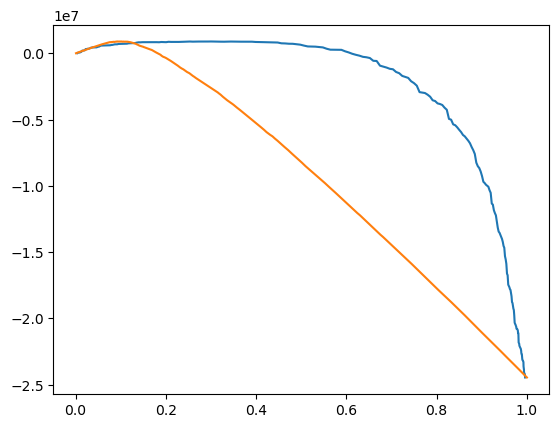

In [469]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(argcumsort['PD'], argcumsort['ProfitCum'])
plt.plot(argcumsort['AR'], argcumsort['ProfitCum'])

In [470]:
argcumsort2=argcumsort.copy()
argcumsort2=argcumsort2.sort_values(by='ProfitCum',ascending=False)
argcumsort2=argcumsort2.reset_index()
print(argcumsort2['ProfitCum'][0])
argcumsort2.head()
#896 902,65

896902.6534822235


,index,PD,Profit,NCum,AR,ProfitCum
0,93,0.299990,896902.653482,1294,0.101284,896902.653482
1,86,0.253127,893517.891030,1166,0.091265,893517.891030
2,92,0.292998,892716.407828,1286,0.100657,892716.407828
3,89,0.272607,891658.597866,1183,0.092595,891658.597866
4,99,0.343843,891547.450700,1349,0.105589,891547.450700


In [471]:
# Scoring code

vars_sc=list(pd.unique(Scorecard[variable_name]))

vars_num=Scorecard[Scorecard[type_name]=='INT'].copy()
vars_sc_num=list(pd.unique(vars_num[variable_name]))

vars_nom=Scorecard[Scorecard[type_name]=='NOM'].copy()
vars_sc_nom=list(pd.unique(vars_nom[variable_name]))

with open('scoring_code.sas','w') as f:
    f.write('proc sql; \n')
    f.write('create table  &zbior._score as \n')
    f.write('select indataset.*  \n')
    for var in vars_sc_num:
        scv=Scorecard[Scorecard[variable_name]==var].copy()
        scv=scv.reset_index()
        f.write(', case \n')
        for i in range(scv.shape[0]):
            war=scv[condition_name][i]
            score=scv[score_name][i]
            if war.count('<')==2:
                f.write('when '+war.rsplit('<',1)[0]+' and '+war.rsplit('<=',1)[1]+' then '+str(score)+' \n')
            if war.count('<')==1 and war.count('<>')==0:
                f.write('when '+war+' then '+str(score)+' \n')
            if war.count('= '+symbol_missing)==1:
                f.write('when '+war.split(' ')[0]+' is null then '+str(score)+' \n')
            if war.count('<> '+symbol_missing)==1:
                f.write('when '+war.split(' ')[0]+' is not null then '+str(score)+' \n')
        score=scv[score_name][0]
        f.write('else '+str(score)+' end as PSC_'+var+' \n')
        f.write(' \n')
        
    for var in vars_sc_nom:
        scv=Scorecard[Scorecard[variable_name]==var].copy()
        scv=scv.reset_index()
        f.write(', case \n')
        index_other=0;
        for i in range(scv.shape[0]):
            war=scv[condition_name][i]
            score=scv[score_name][i]
            if war.count(',')==0 and war.count(symbol_other)==0:
                f.write('when '+var+' in ('+"'"+war+"'"+') then '+str(score)+' \n')
            if war.count(',')>0 and war.count(symbol_other)==0:
                f.write('when '+var+' in ('+"'"+war.split(', ')[0]+"'")
                for j in range(war.count(',')):
                    f.write(', '+"'"+war.split(', ')[j+1]+"'")
                f.write(') then '+str(score)+' \n')
            if war.count(symbol_other)==1:
                index_other=i
        score=scv[score_name][index_other]
        f.write('else '+str(score)+' end as PSC_'+var+' \n')
        f.write(' \n')
    
    f.write('/* , 1/(1+exp(-('+str(model_cal.params[0])+'*(0.0')
    for var in vars_sc:            
        f.write('+ calculated PSC_'+var)
    f.write(')+('+str(model_cal.params[1])+')))) as '+prob_event+' */ \n')
    f.write(' \n')
    
    f.write(', 0.0 \n')
    for var in vars_sc:            
        f.write('+ calculated PSC_'+var+' ')
    f.write(' as SCORECARD_POINTS \n')
    
    f.write(' \n')
    f.write('from &zbior as indataset; \n')
    f.write('quit; \n')

In [472]:
#!pip3 install varclushi

In [473]:
#!pip3 install factor_analyzer

In [474]:
# Variable clustering
from varclushi import VarClusHi

In [475]:
# demo1_df.drop('quality',axis=1,inplace=True)
demo1_vc = VarClusHi(logit_train[vars_selected],maxeigval2=0.1,maxclus=None)
demo1_vc.varclus()

In [476]:
writer = pd.ExcelWriter('Variable_Clustering.xlsx', engine='xlsxwriter')

demo1_vc.info.to_excel(writer, sheet_name='Info', index_label=None, index=False)
demo1_vc.rsquare.to_excel(writer, sheet_name='Clusters', index_label=None, index=False)

writer.save()
writer.close()

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [477]:
#!pip3 install shap

In [478]:
#import shap

In [479]:
#!conda install -c conda-forge shap

In [480]:
#!pip3 install numpy==1.23.1

In [481]:
# XAI Explainable artificial intelligence

features=list(result['Efects'][variable_name].copy())
features.remove('Intercept')

# X=logit_train[features]
# y=logit_train[target_name]

X=scored_train[features]
y=scored_train[target_name]

#import shap
logmodel = LogisticRegression()
logmodel.fit(X,y)

for i,v in enumerate(features):
#     logmodel.coef_[0][i]=result['Efects']['Estimation'][i]
    logmodel.coef_[0][i]=1.0
    

logmodel.intercept_=0.0

#explainer=shap.LinearExplainer(logmodel,X)
#shap_values=explainer(X)



In [482]:
 print(logmodel.coef_,logmodel.intercept_)

[[1. 1. 1. 1. 1. 1.]] 0.0


In [483]:
#shap.summary_plot(shap_values,X,plot_type='bar')

In [484]:
#shap.plots.bar(shap_values)

In [485]:
#shap.summary_plot(shap_values,X,plot_type='violin')

In [486]:
#shap.plots.beeswarm(shap_values)

In [487]:
#shap.waterfall_plot(shap_values[0])

In [488]:
#shap.initjs()
#shap.plots.force(shap_values[0])

In [489]:
suma=0
for v in features:
    print(v, X[v][0])
    suma=suma+X[v][0]
print('Score',suma)

act_ccss_n_statC -17.0
act_ccss_maxdue 10.0
ags6_Min_CMaxA_Due 1.0
app_number_of_children 10.0
act_cc -1.0
app_income 36.0
Score 39.0


In [490]:
#shap_values[0]

In [491]:
for v in features:
    a=X[v][0]-X[v].mean()
    print(v, a)

act_ccss_n_statC -19.103805394990367
act_ccss_maxdue 6.358863198458574
ags6_Min_CMaxA_Due 9.747350674373795
app_number_of_children 15.123916184971097
act_cc -1.6847302504816954
app_income 19.0634633911368


In [492]:
XS=X.copy()
XS['sum']=0.0
for v in features:
   XS['sum']=XS['sum']+X[v]

XS['sum'].mean()

9.494942196531792

In [493]:
#XShap=pd.DataFrame(shap_values.values)
#XShap['sum']=0.0
#for i,v in enumerate(features):
#    XShap['sum']=XShap['sum']+XShap[i]
    
#XShap['sum'].mean()

In [494]:
#a=shap_values.base_values.mean()+XShap['sum'].mean()
#a
len([896902.65, 914148.5631010146, 895811.5758456348, 920026.9987934805, 927931.8307756819])

5

In [495]:
# dict = {'gini': [0.73, 0.7299900350659401, 0.7266378402931, 0.7350075157451894, 0.7370777728407707],
#         'profit':[896902.65, 914148.5631010146, 895811.5758456348, 920026.9987934805, 927931.8307756819],
#         'description':["number_vars=15- number_features=6", "number_vars=12 number_features=6", "number_vars=10 number_features=5" "number_vars=15 number_features=7", "number_vars=20 number_features=70.6256871649501146","ncategories_nom=5 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6"]}
# df = pd.DataFrame(dict)
 
# # append data frame to CSV file
# df.to_csv('results.csv', index=False)
description_results

'ncategories_nom=5number_vars=12 number_features=6'

In [496]:
data = {
    'gini': [gini],
    'profit': [argcumsort2['ProfitCum'][0]],
    'description': [description_results]
}
# Make data frame of above data
df = pd.DataFrame(data)
 
# append data frame to CSV file
df.to_csv('results.csv', mode='a', index=False, header=False)

In [497]:
df_results = pd.read_csv("results.csv")
df_results.head(10)

,gini,profit,description
0,0.730000,896902.650000,number_vars=15- number_features=6
1,0.729990,914148.563101,number_vars=12 number_features=6
2,0.726638,895811.575846,number_vars=10 number_features=5number_vars=15...
3,0.735008,920026.998793,number_vars=20 number_features=70.625687164950...
4,0.737078,927931.830776,ncategories_nom=5 - & (Gini_vars[delta_gini]<0...
5,0.625687,799338.516760,ncategories_nom=5 - & (Gini_vars[delta_gini]<0...
6,0.625687,799338.516760,ncategories_nom=3 - & (Gini_vars[delta_gini]<0...
7,0.625687,799338.516760,ncategories_nom=4 - & (Gini_vars[delta_gini]<0...
8,0.733273,896902.653482,ncategories_nom=4 - & (Gini_vars[delta_gini]<0...
9,0.733273,896902.653482,ncategories_nom=5 - & (Gini_vars[delta_gini]<0...


In [498]:
# decorator
def pandas_display(func):
    default_1 = pd.options.display.max_rows
    default_2 = pd.options.display.max_colwidth
    def wrapper(_df, exclude_cols=None, properties=None, limit_float=2):
        pd.options.display.max_rows = 1000
        pd.options.display.max_colwidth = None
        func(_df, exclude_cols, properties, limit_float)
        pd.options.display.max_rows = default_1
        pd.options.display.max_colwidth = default_2
    return wrapper
    
    
@pandas_display
def display_df(self, exclude_cols, properties, limit_float):
    if exclude_cols is not None:
        if not isinstance(exclude_cols, list):
            exclude_cols = list(exclude_cols)
        cols = [x for x in self.columns.values if x not in set(exclude_cols)]
        self = self[cols]

    if not properties:
        properties = {
            'text-align': 'left',
            'white-space': 'pre-wrap',
            'word-wrap': 'break-word',
            'width': '230px',
            'max-width': '230px',
        }
        
    a = self.style.set_properties(**properties)
#     if limit_float is not None:
#         a.format(thousands=',', precision=limit_float)
    display(a)
    
d = display_df
pd.DataFrame.d = d

In [499]:
df_results.d()

,gini,profit,description
0,0.730000,896902.650000,number_vars=15- number_features=6
1,0.729990,914148.563101,number_vars=12 number_features=6
2,0.726638,895811.575846,number_vars=10 number_features=5number_vars=15 number_features=7
3,0.735008,920026.998793,number_vars=20 number_features=70.6256871649501146
4,0.737078,927931.830776,ncategories_nom=5 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6
5,0.625687,799338.516760,ncategories_nom=5 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6
6,0.625687,799338.516760,ncategories_nom=3 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6
7,0.625687,799338.516760,ncategories_nom=4 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6
8,0.733273,896902.653482,ncategories_nom=4 - & (Gini_vars[delta_gini]<0.1 - number_vars=12 number_features=6
9,0.733273,896902.653482,ncategories_nom=5 - & (Gini_vars[delta_gini]<0.1 - number_vars=12 number_features=6
